### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

In [1]:
%matplotlib inline

from __future__ import division

import tensorflow as tf
import skimage.io as io
import numpy as np
from nets import vgg
from preprocessing import vgg_preprocessing
from libs.scale_input_image import scale_randomly_image_with_annotation_with_fixed_size_output
from libs.training import get_valid_logits_and_labels
from libs.training import get_labels_from_annotation
# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)
import sys
import os
from matplotlib import pyplot as plt
slim = tf.contrib.slim

# Data processing

In [2]:
#0:   background
#1:   aeroplane
#2:   bicycle
#3:   bird
#4:   boat
#5:   bottle
#6:   bus
#7:   car
#8:   cat
#9:   chair
#10:  cow
#11:  diningtable
#12:  dog
#13:  horse
#14:  motorbike
#15:  person
#16:  pottedplant
#17:  sheep
#18:  sofa
#19:  train
#20:  tvmonitor
#255: undefined/don't care
number_of_classes = 21
class_labels = [v for v in range((number_of_classes+1))]
class_labels[-1] = 255

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [3]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [4]:
training_filenames = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/ImageSets/Segmentation/train.txt"
training_dir = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/JPEGImages"
annotations_dir = "/home/thalles_silva/DataPublic/PascalVoc2012/train/VOC2012/SegmentationClass_1D"
log_folder = '/home/thalles_silva/Thalles/image-segmentation/log_folder'
checkpoints_dir = '/home/thalles_silva/Thalles/image-segmentation/vgg'
vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

In [5]:
def model_input():
    is_training_placeholder = tf.placeholder(tf.bool)
    return is_training_placeholder

In [6]:
upsample_filter_factor_2_np = bilinear_upsample_weights(factor=2,
                                                        number_of_classes=number_of_classes)

upsample_filter_factor_8_np = bilinear_upsample_weights(factor=8,
                                                         number_of_classes=number_of_classes)

upsample_filter_factor_2_tensor = tf.constant(upsample_filter_factor_2_np)
upsample_filter_factor_8_tensor = tf.constant(upsample_filter_factor_8_np)

In [7]:
def model(processed_images, number_of_classes=21, is_training=True):

    with slim.arg_scope(vgg.vgg_arg_scope()):

        last_layer_logits, end_points = vgg.vgg_16(processed_images,
                                                   num_classes=number_of_classes,
                                                   is_training=is_training,
                                                   spatial_squeeze=False,
                                                   fc_conv_padding='SAME')


    last_layer_logits_shape = tf.shape(last_layer_logits)


    # Calculate the ouput size of the upsampled tensor
    last_layer_upsampled_by_factor_2_logits_shape = tf.stack([
                                                          last_layer_logits_shape[0],
                                                          last_layer_logits_shape[1] * 2,
                                                          last_layer_logits_shape[2] * 2,
                                                          last_layer_logits_shape[3]
                                                         ])

    # Perform the upsampling
    last_layer_upsampled_by_factor_2_logits = tf.nn.conv2d_transpose(last_layer_logits,
                                                                     upsample_filter_factor_2_tensor,
                                                                     output_shape=last_layer_upsampled_by_factor_2_logits_shape,
                                                                     strides=[1, 2, 2, 1])

    ## Adding the skip here for FCN-16s model

    # We created vgg in the fcn_8s name scope -- so
    # all the vgg endpoints now are prepended with fcn_8s name
    pool4_features = end_points['vgg_16/pool4']

    # We zero initialize the weights to start training with the same
    # accuracy that we ended training FCN-32s

    pool4_logits = slim.conv2d(pool4_features,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               weights_initializer=tf.zeros_initializer,
                               scope='seg_vars/pool4')

    fused_last_layer_and_pool4_logits = pool4_logits + last_layer_upsampled_by_factor_2_logits

    fused_last_layer_and_pool4_logits_shape = tf.shape(fused_last_layer_and_pool4_logits)

    # Calculate the ouput size of the upsampled tensor
    fused_last_layer_and_pool4_upsampled_by_factor_2_logits_shape = tf.stack([
                                                                  fused_last_layer_and_pool4_logits_shape[0],
                                                                  fused_last_layer_and_pool4_logits_shape[1] * 2,
                                                                  fused_last_layer_and_pool4_logits_shape[2] * 2,
                                                                  fused_last_layer_and_pool4_logits_shape[3]
                                                                 ])

    # Perform the upsampling
    fused_last_layer_and_pool4_upsampled_by_factor_2_logits = tf.nn.conv2d_transpose(fused_last_layer_and_pool4_logits,
                                                                upsample_filter_factor_2_tensor,
                                                                output_shape=fused_last_layer_and_pool4_upsampled_by_factor_2_logits_shape,
                                                                strides=[1, 2, 2, 1])


    ## Adding the skip here for FCN-8s model
    pool3_features = end_points['vgg_16/pool3']

    # We zero initialize the weights to start training with the same
    # accuracy that we ended training FCN-32s

    pool3_logits = slim.conv2d(pool3_features,
                               number_of_classes,
                               [1, 1],
                               activation_fn=None,
                               normalizer_fn=None,
                               weights_initializer=tf.zeros_initializer,
                               scope='seg_vars/pool3')


    fused_last_layer_and_pool4_logits_and_pool_3_logits = pool3_logits + \
                                    fused_last_layer_and_pool4_upsampled_by_factor_2_logits


    fused_last_layer_and_pool4_logits_and_pool_3_logits_shape = tf.shape(fused_last_layer_and_pool4_logits_and_pool_3_logits)


    # Calculate the ouput size of the upsampled tensor
    fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits_shape = tf.stack([
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[0],
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[1] * 8,
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[2] * 8,
                                                                  fused_last_layer_and_pool4_logits_and_pool_3_logits_shape[3]
                                                                 ])

    # Perform the upsampling
    fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits = tf.nn.conv2d_transpose(fused_last_layer_and_pool4_logits_and_pool_3_logits,
                                                                upsample_filter_factor_8_tensor,
                                                                output_shape=fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits_shape,
                                                                strides=[1, 8, 8, 1])

    return fused_last_layer_and_pool4_logits_and_pool_3_upsampled_by_factor_8_logits

In [8]:
def model_loss(upsampled_by_factor_16_logits, labels):
    #labels = tf.squeeze(labels)
    #valid_labels_batch_tensor, valid_logits_batch_tensor = get_valid_logits_and_labels(annotation_batch_tensor=labels,
    #                                                                                   logits_batch_tensor=upsampled_by_factor_16_logits,
    #                                                                                   class_labels=class_labels)
    


    #cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=valid_logits_batch_tensor,
    #                                                          labels=valid_labels_batch_tensor)
    
    cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=upsampled_by_factor_16_logits,
                                                              labels=labels)
    cross_entropy_mean = tf.reduce_mean(cross_entropies)
    
    # Add summary op for the loss -- to be able to see it in tensorboard.
    tf.summary.scalar('cross_entropy_loss', cross_entropy_mean)

    # Tensor to get the final prediction for each pixel -- pay 
    # attention that we don't need softmax in this case because
    # we only need the final decision. If we also need the respective
    # probabilities we will have to apply softmax.
    pred = tf.argmax(upsampled_by_factor_16_logits, dimension=3)
    probabilities = tf.nn.softmax(upsampled_by_factor_16_logits)
    
    return cross_entropy_mean, pred, probabilities

In [9]:
def model_optimizer(cross_entropy_sum, learning_rate):
    with tf.variable_scope("adam_vars"):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_sum)
    return train_step

In [10]:
file = open(training_filenames, 'r')
images_filenale_list = [line for line in file]

In [11]:
# get an image for testing the network
image_path = "/home/thalles_silva/Thalles/image-segmentation/data/imgs/cat.jpg"
annotation_path = "/home/thalles_silva/Thalles/image-segmentation/data/imgs/cat_annotation.png"

image_tensor = tf.read_file(image_path)
image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
image_tensor = tf.cast(image_tensor, tf.float32)
image_tensor = _mean_image_subtraction(image_tensor,[_R_MEAN, _G_MEAN, _B_MEAN])
image_tensor = tf.expand_dims(image_tensor, axis=0) # (1, ?, ?, 3) # BATCH,WIDTH,HEIGHTxDEPTH

annotation_tensor = tf.read_file(annotation_path)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)
annotation_masks_tensor = get_labels_from_annotation(tf.squeeze(annotation_tensor), class_labels)
annotation_masks_tensor = tf.expand_dims(annotation_masks_tensor, axis=0) # BATCH,WIDTH,HEIGHT

In [12]:
is_training_placeholder = model_input()

upsampled_by_factor_16_logits = model(image_tensor, number_of_classes=number_of_classes, is_training=True)

cross_entropy_sum, pred, probabilities = model_loss(upsampled_by_factor_16_logits, annotation_masks_tensor)

train_step = model_optimizer(cross_entropy_sum, learning_rate=0.00001)

In [13]:
# Define the accuracy metric: Mean Intersection Over Union
miou, update_op = slim.metrics.streaming_mean_iou(predictions=pred,
                                                   labels=annotation_tensor,
                                                   num_classes=number_of_classes)

In [14]:
# get all segmentation model vars, these are the variables we create to perform 
# the segmentation upsampling layers
model_variables = [ var.op.name for var in slim.get_variables(scope="seg_vars") ]

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
exclude_vars = model_variables + ['vgg_16/fc8', 'adam_vars']
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=exclude_vars)

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# get the segmentation upsampling variables to be initialized 
model_variables = slim.get_variables(scope="seg_vars")

# Put all summary ops into one op. Produces string when you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# the VGG net variables.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

INFO:tensorflow:Restoring parameters from /home/thalles_silva/Thalles/image-segmentation/vgg/vgg_16.ckpt


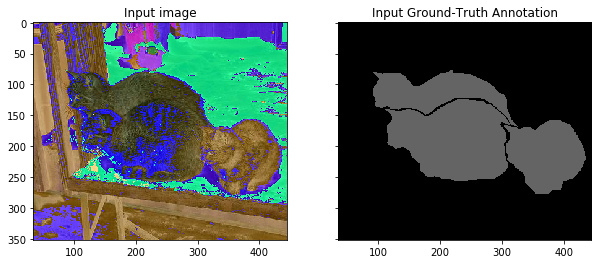

Train step: 0 	Traing Loss: 3.47862 	mIOU: 0.00734087


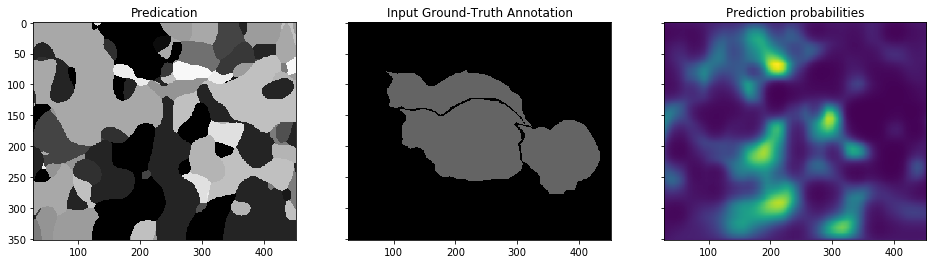

Train step: 1 	Traing Loss: 1.13459 	mIOU: 0.024018


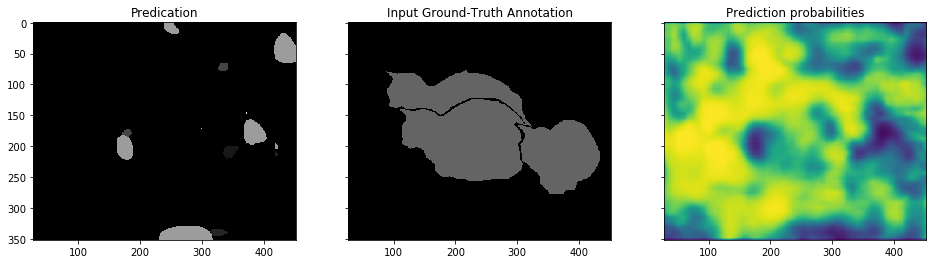

Train step: 2 	Traing Loss: 0.411667 	mIOU: 0.0359724


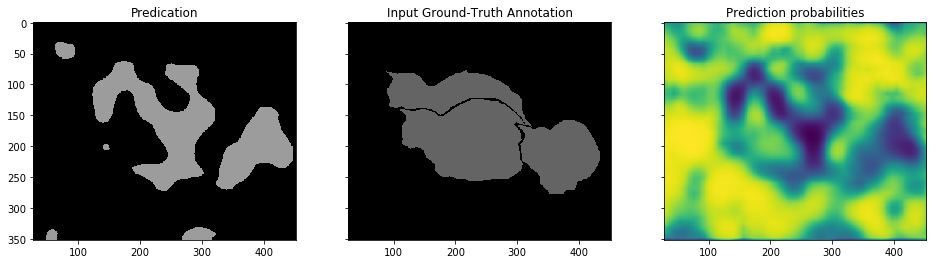

Train step: 3 	Traing Loss: 0.258353 	mIOU: 0.0454995


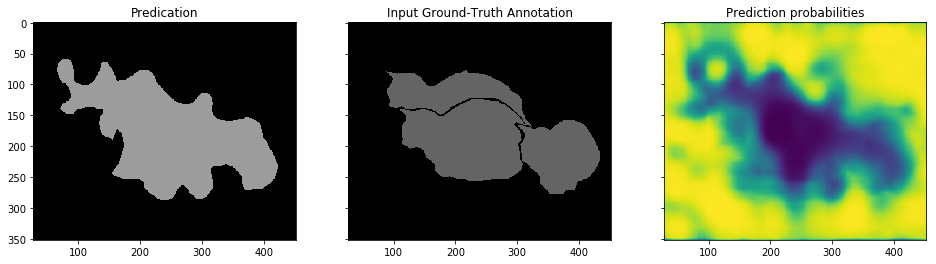

Train step: 4 	Traing Loss: 0.223683 	mIOU: 0.051416


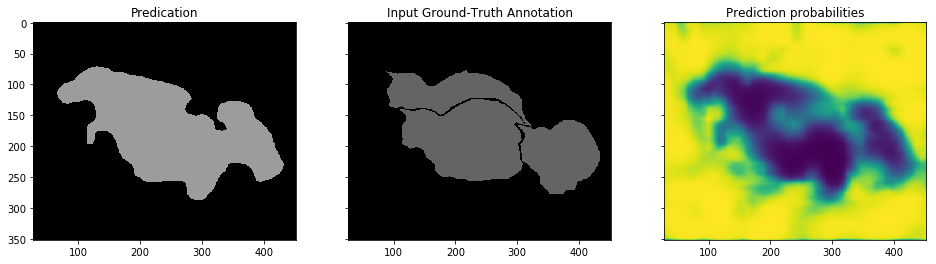

Train step: 5 	Traing Loss: 0.139363 	mIOU: 0.0566726


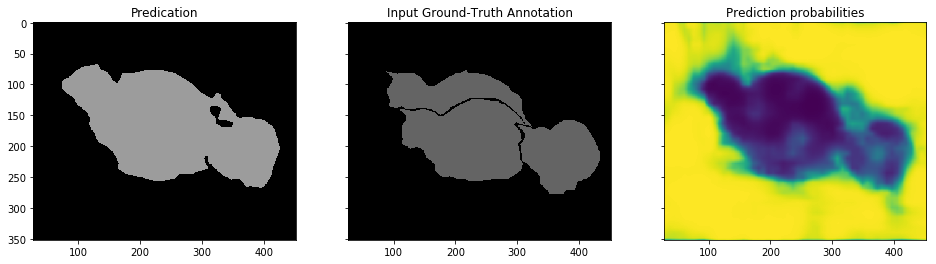

Train step: 6 	Traing Loss: 0.128468 	mIOU: 0.0601633


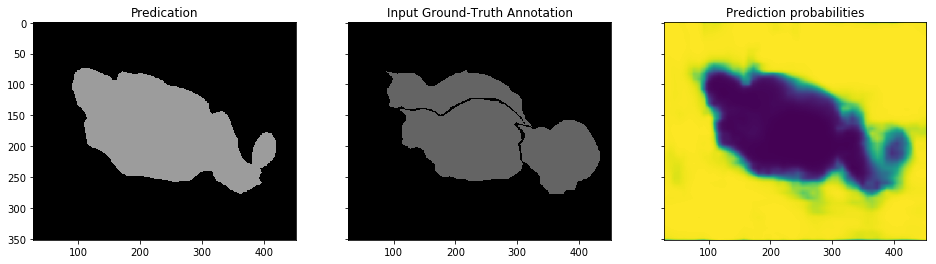

Train step: 7 	Traing Loss: 0.109956 	mIOU: 0.0630611


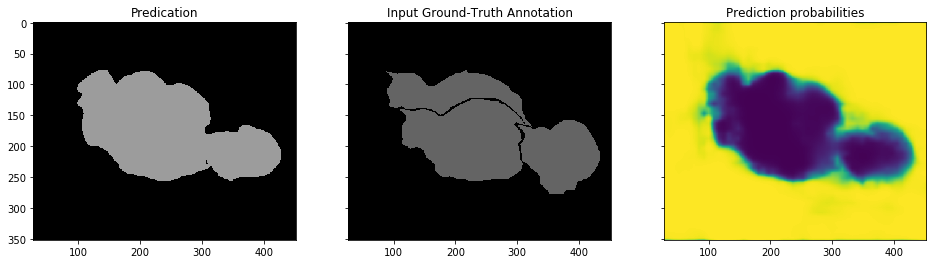

Train step: 8 	Traing Loss: 0.11998 	mIOU: 0.0651776


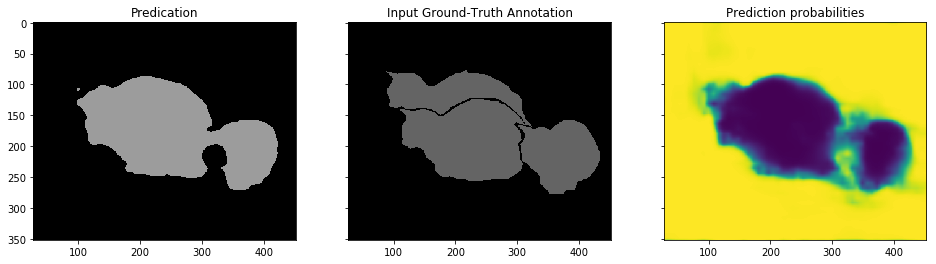

Train step: 9 	Traing Loss: 0.122047 	mIOU: 0.0670877


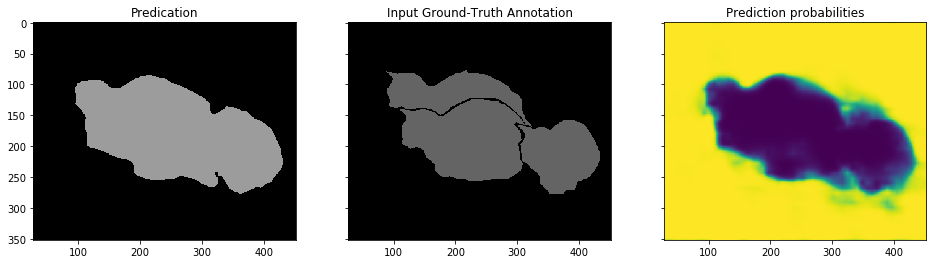

Train step: 10 	Traing Loss: 0.0818274 	mIOU: 0.0689407


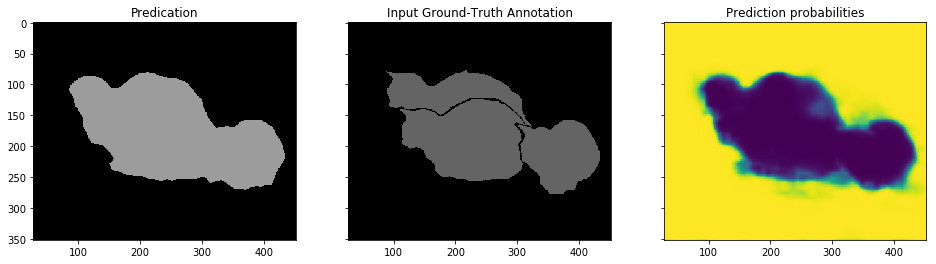

Train step: 11 	Traing Loss: 0.097197 	mIOU: 0.0702847


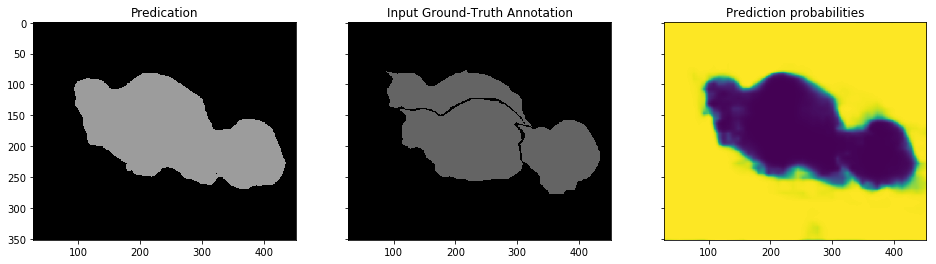

Train step: 12 	Traing Loss: 0.105888 	mIOU: 0.0714433


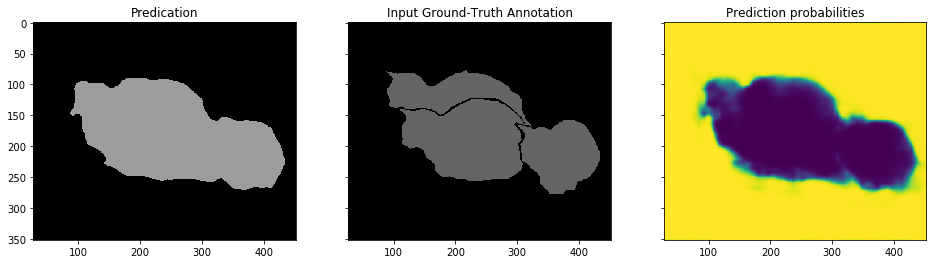

Train step: 13 	Traing Loss: 0.0895832 	mIOU: 0.0725239


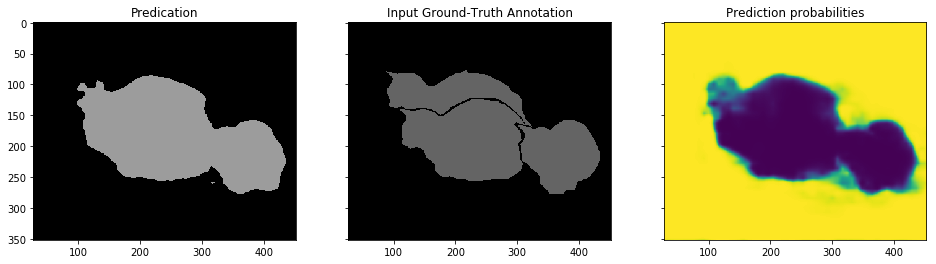

Train step: 14 	Traing Loss: 0.0776349 	mIOU: 0.0735151


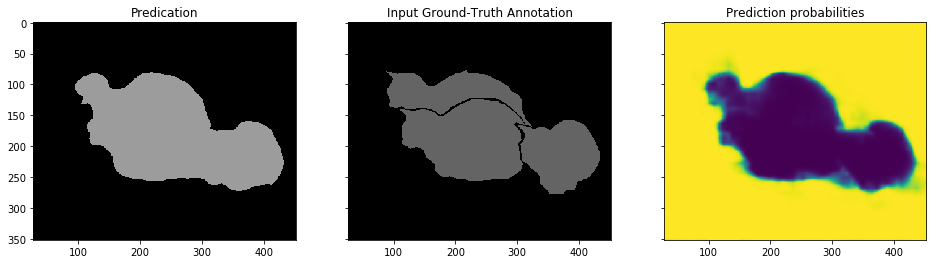

Train step: 15 	Traing Loss: 0.0656532 	mIOU: 0.0744838


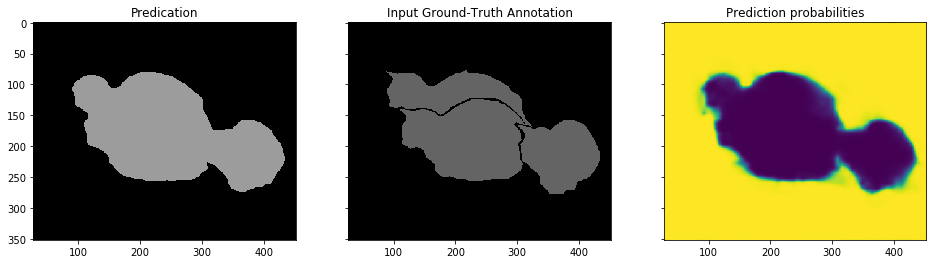

Train step: 16 	Traing Loss: 0.0710385 	mIOU: 0.0753199


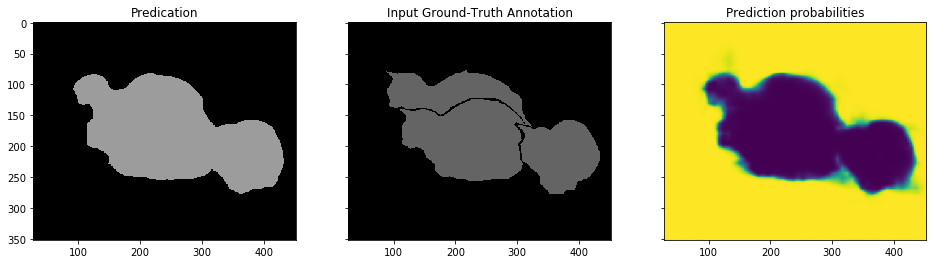

Train step: 17 	Traing Loss: 0.0623617 	mIOU: 0.0760958


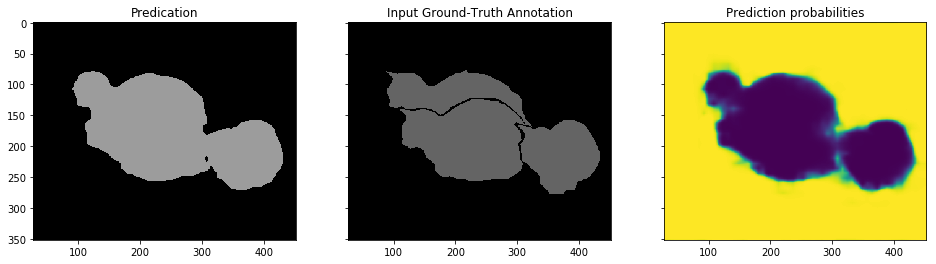

Train step: 18 	Traing Loss: 0.0599574 	mIOU: 0.076813


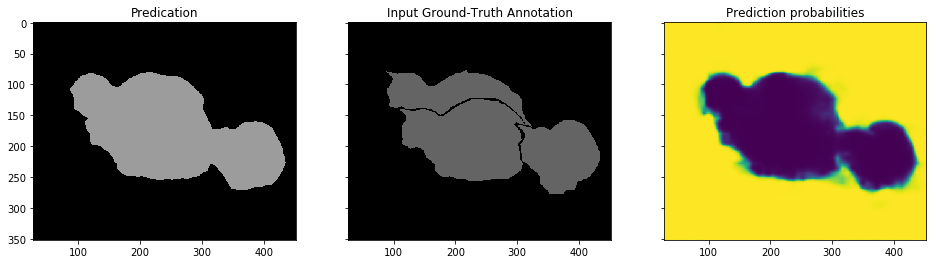

Train step: 19 	Traing Loss: 0.0611996 	mIOU: 0.0774524


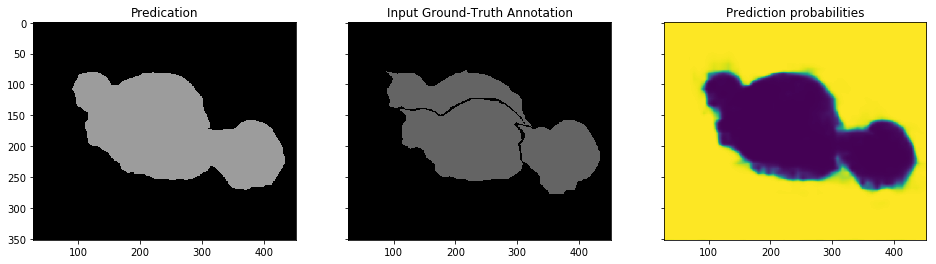

Train step: 20 	Traing Loss: 0.0584464 	mIOU: 0.0780315


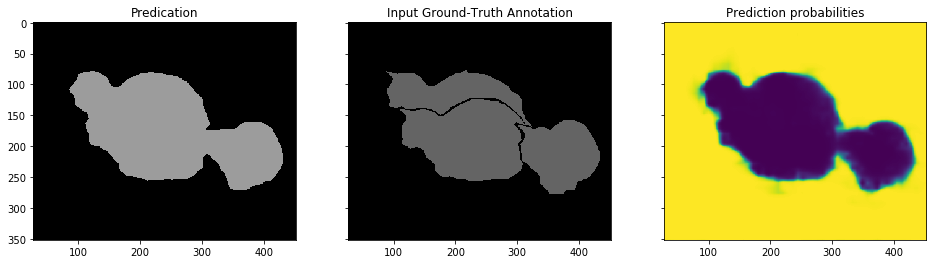

Train step: 21 	Traing Loss: 0.0563489 	mIOU: 0.0785576


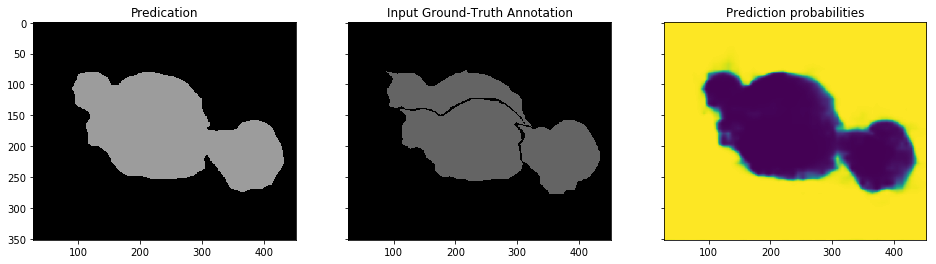

Train step: 22 	Traing Loss: 0.0558811 	mIOU: 0.0790605


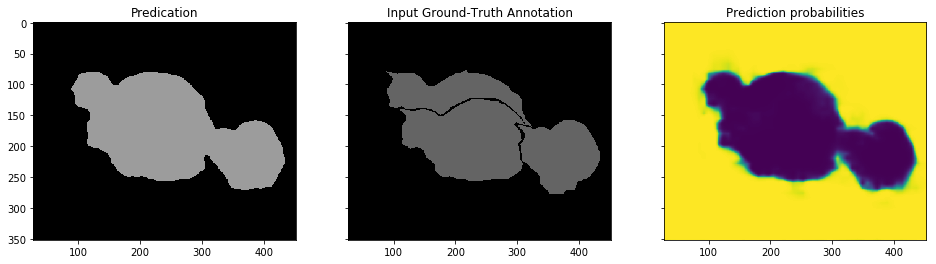

Train step: 23 	Traing Loss: 0.0567206 	mIOU: 0.0795148


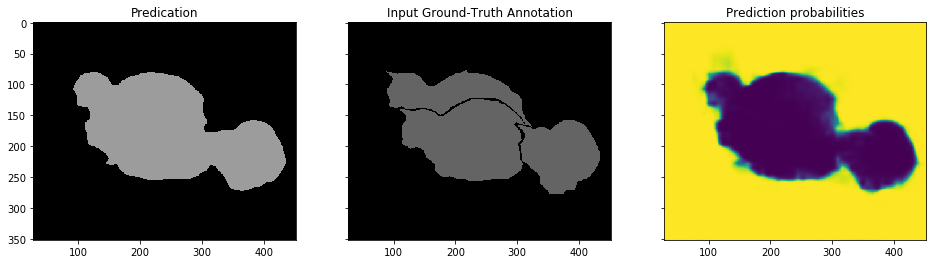

Train step: 24 	Traing Loss: 0.0523021 	mIOU: 0.07995


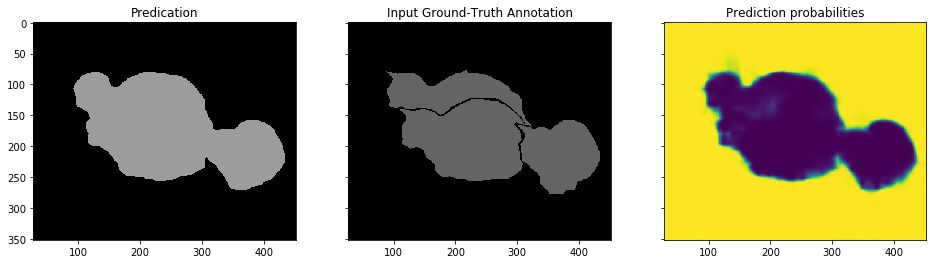

Train step: 25 	Traing Loss: 0.0531912 	mIOU: 0.0803454


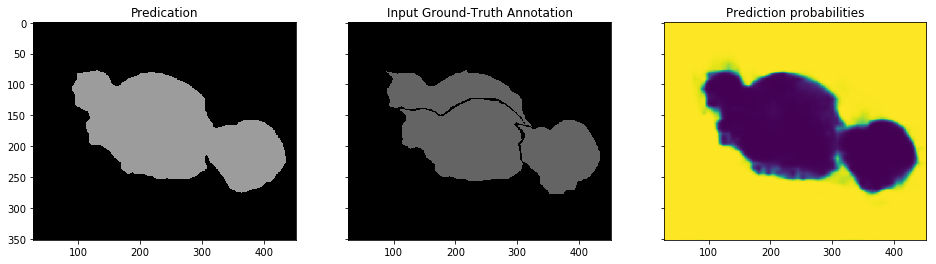

Train step: 26 	Traing Loss: 0.0477467 	mIOU: 0.0807254


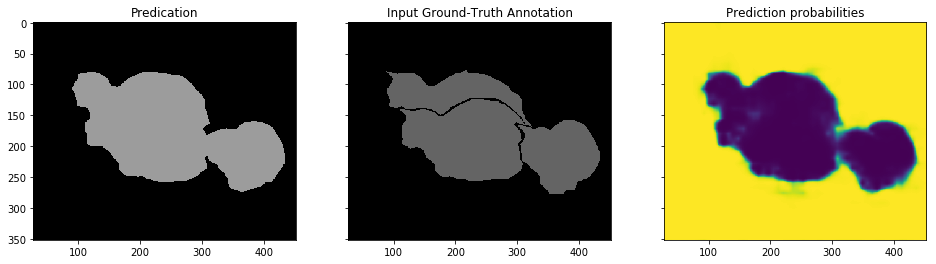

Train step: 27 	Traing Loss: 0.0500767 	mIOU: 0.0810734


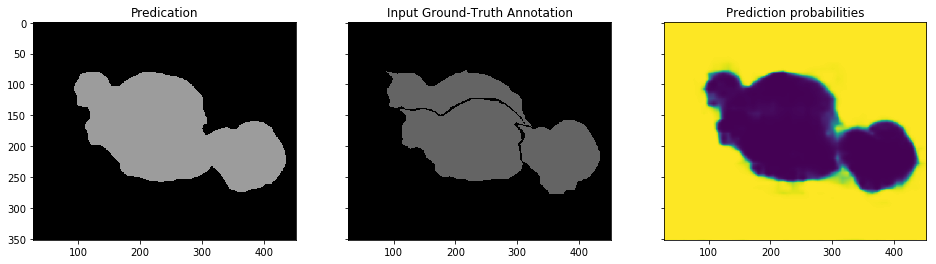

Train step: 28 	Traing Loss: 0.046076 	mIOU: 0.0814075


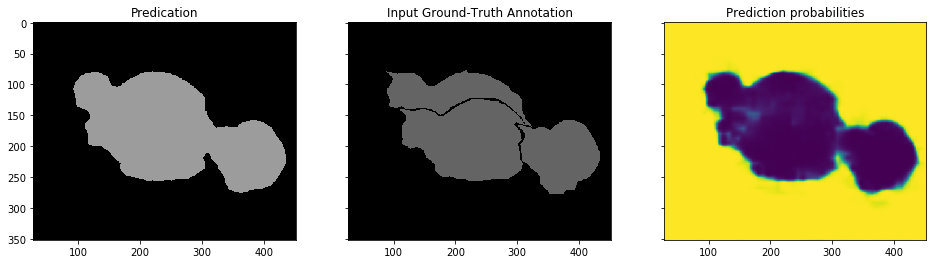

Train step: 29 	Traing Loss: 0.0431138 	mIOU: 0.081729


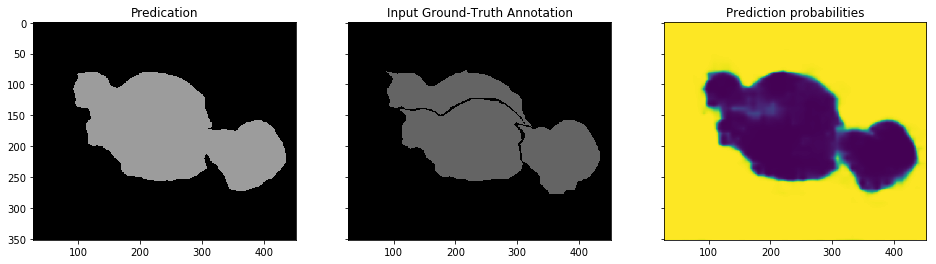

Train step: 30 	Traing Loss: 0.044793 	mIOU: 0.0820301


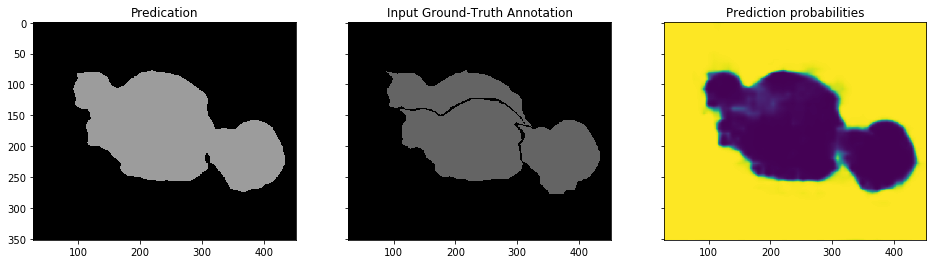

Train step: 31 	Traing Loss: 0.0429824 	mIOU: 0.082311


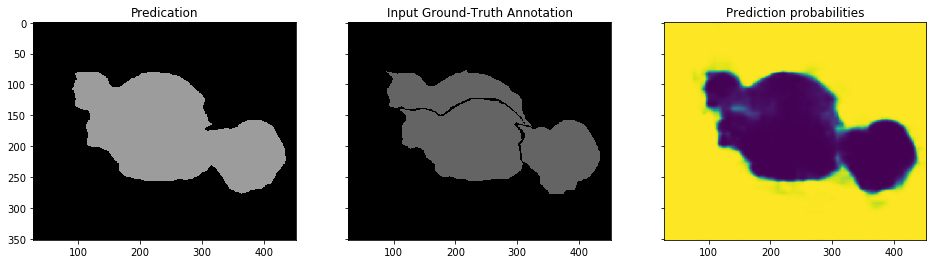

Train step: 32 	Traing Loss: 0.0415621 	mIOU: 0.082577


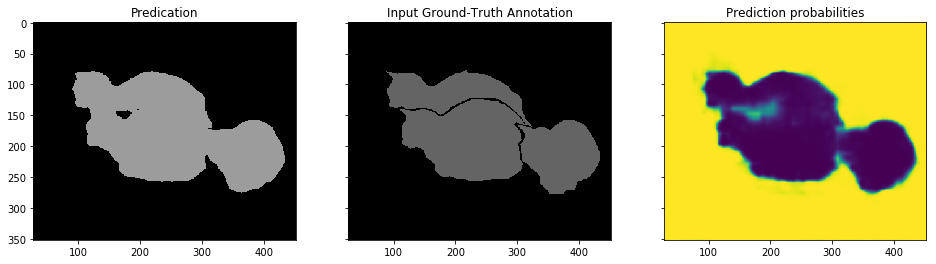

Train step: 33 	Traing Loss: 0.0436622 	mIOU: 0.0828264


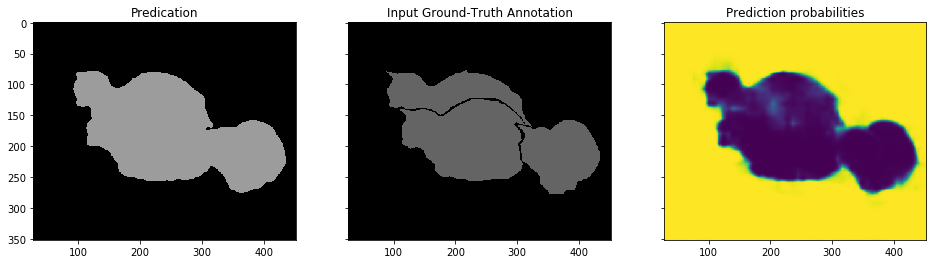

Train step: 34 	Traing Loss: 0.0426792 	mIOU: 0.0830748


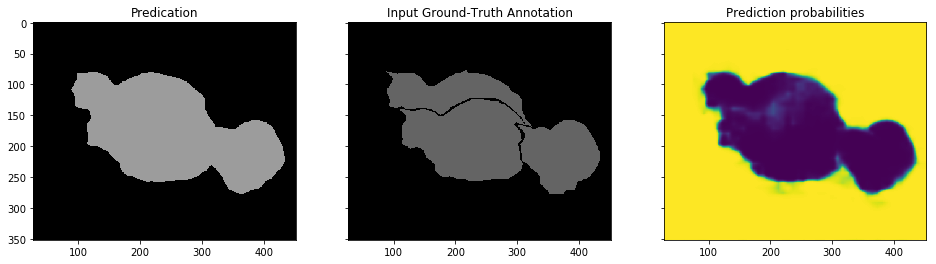

Train step: 35 	Traing Loss: 0.0415756 	mIOU: 0.0833053


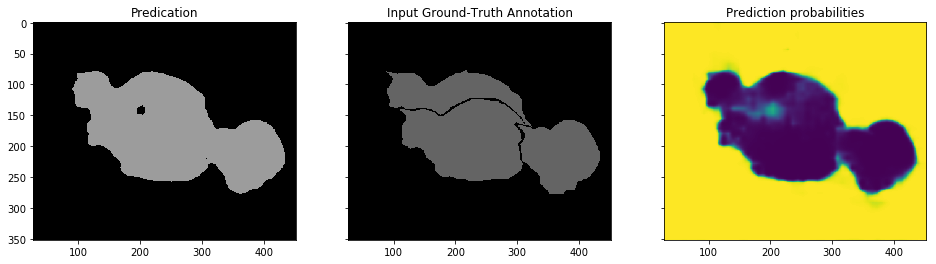

Train step: 36 	Traing Loss: 0.0398594 	mIOU: 0.0835251


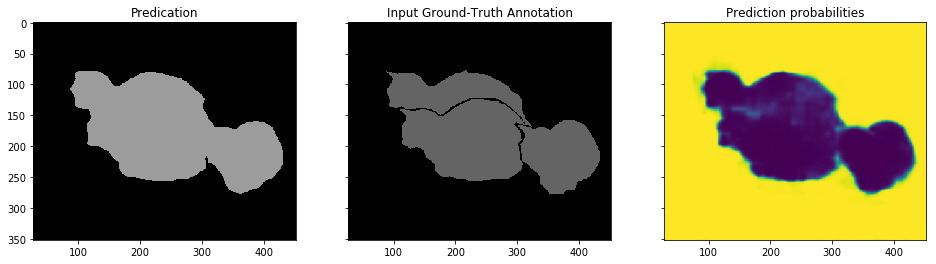

Train step: 37 	Traing Loss: 0.0390265 	mIOU: 0.0837452


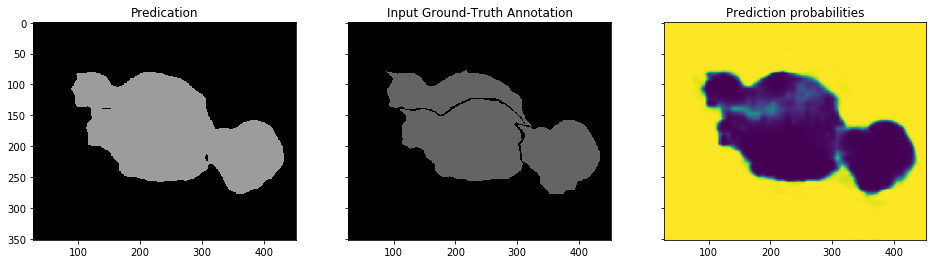

Train step: 38 	Traing Loss: 0.0427271 	mIOU: 0.0839482


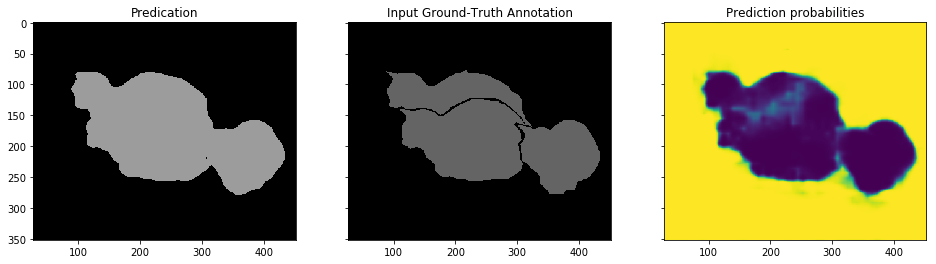

Train step: 39 	Traing Loss: 0.0406904 	mIOU: 0.0841273


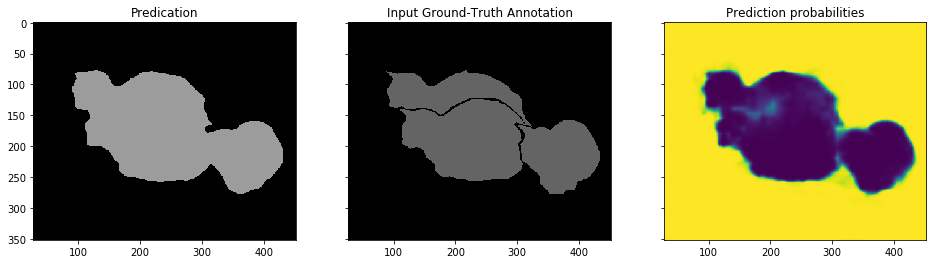

Train step: 40 	Traing Loss: 0.0419122 	mIOU: 0.0843038


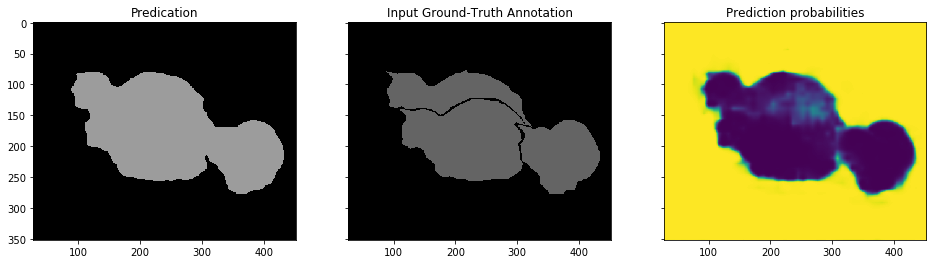

Train step: 41 	Traing Loss: 0.03938 	mIOU: 0.0844746


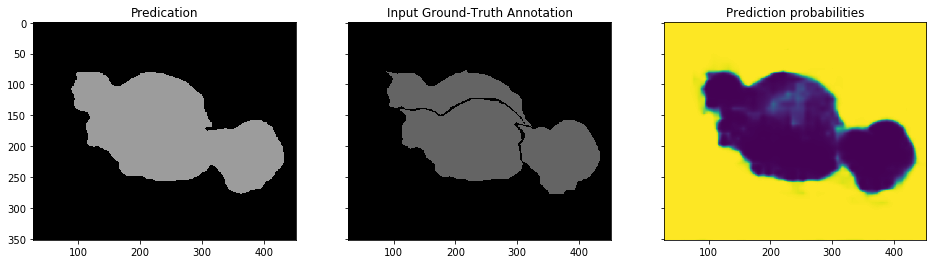

Train step: 42 	Traing Loss: 0.0374489 	mIOU: 0.0846417


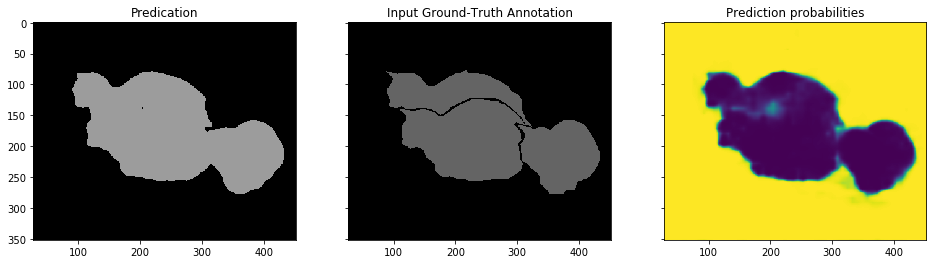

Train step: 43 	Traing Loss: 0.0368181 	mIOU: 0.0848025


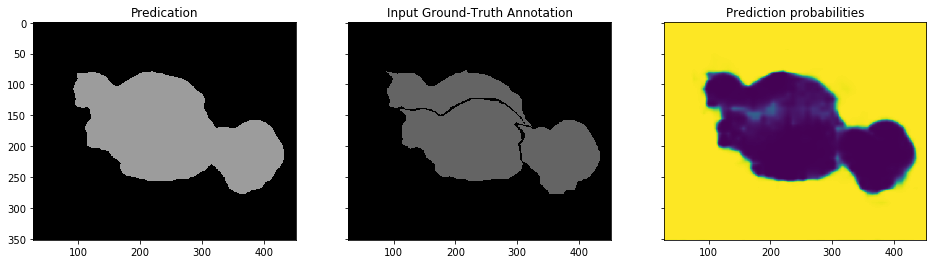

Train step: 44 	Traing Loss: 0.0396233 	mIOU: 0.0849544


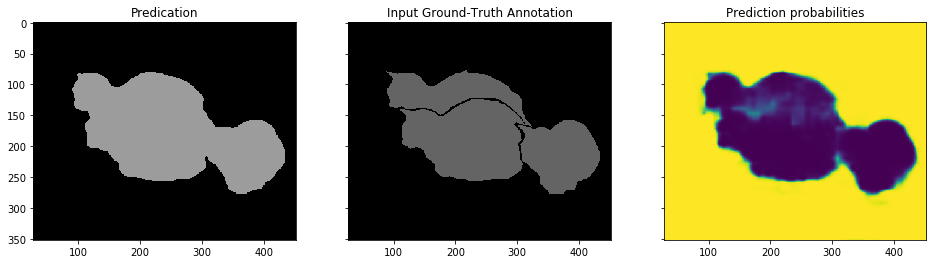

Train step: 45 	Traing Loss: 0.0387604 	mIOU: 0.0850983


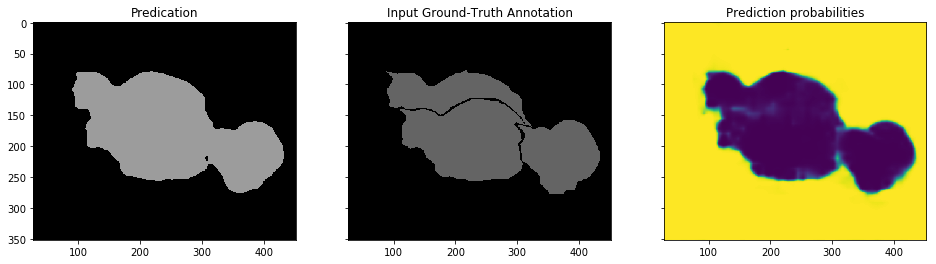

Train step: 46 	Traing Loss: 0.0398567 	mIOU: 0.0852359


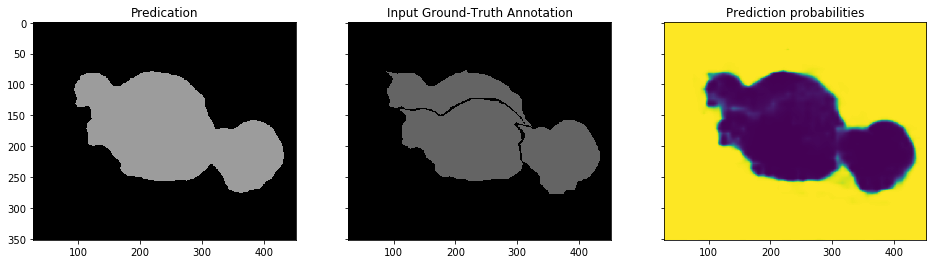

Train step: 47 	Traing Loss: 0.0365646 	mIOU: 0.0853738


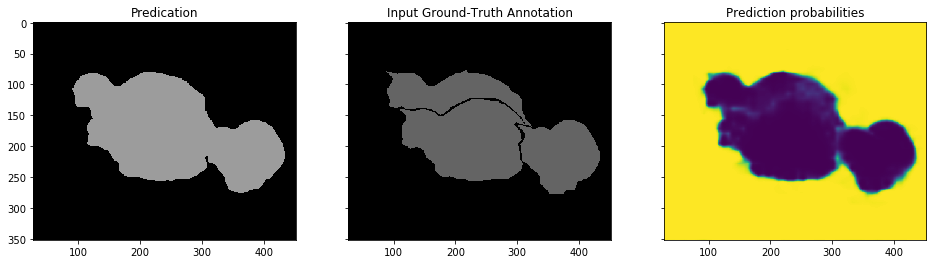

Train step: 48 	Traing Loss: 0.0388773 	mIOU: 0.0855091


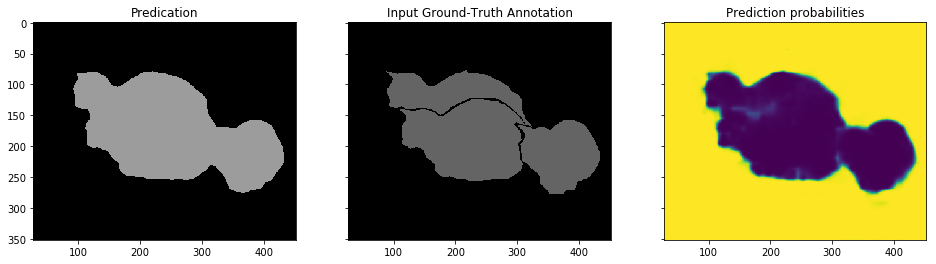

Train step: 49 	Traing Loss: 0.0371644 	mIOU: 0.0856321


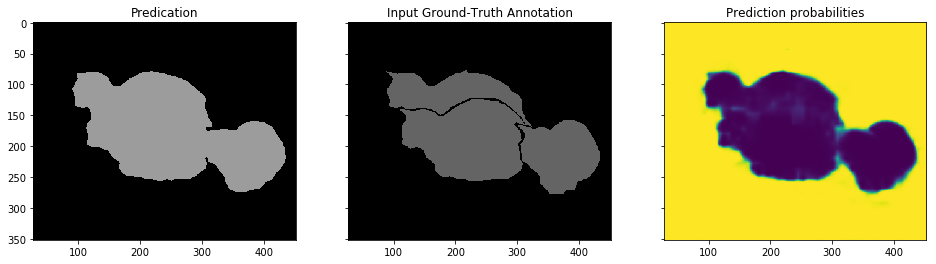

Train step: 50 	Traing Loss: 0.0367892 	mIOU: 0.085756


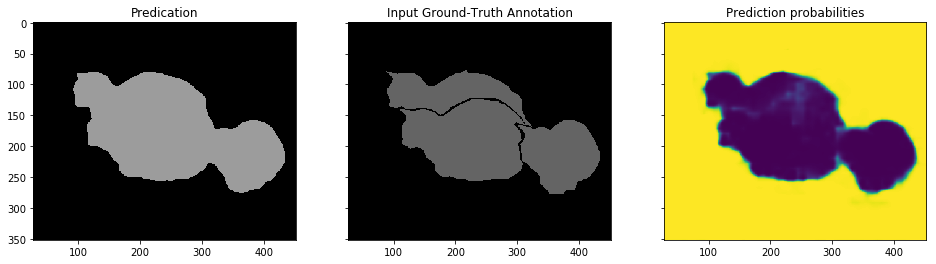

Train step: 51 	Traing Loss: 0.0361485 	mIOU: 0.0858751


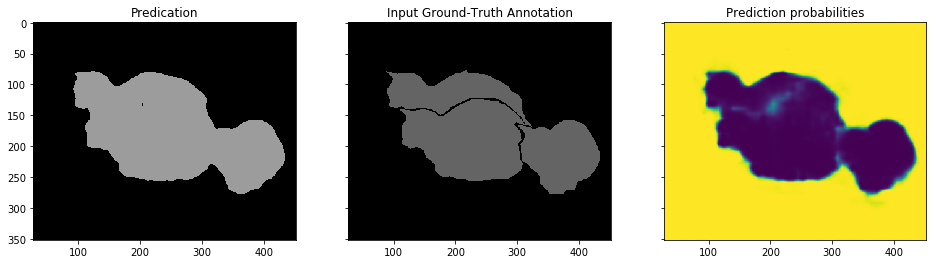

Train step: 52 	Traing Loss: 0.0382477 	mIOU: 0.0859837


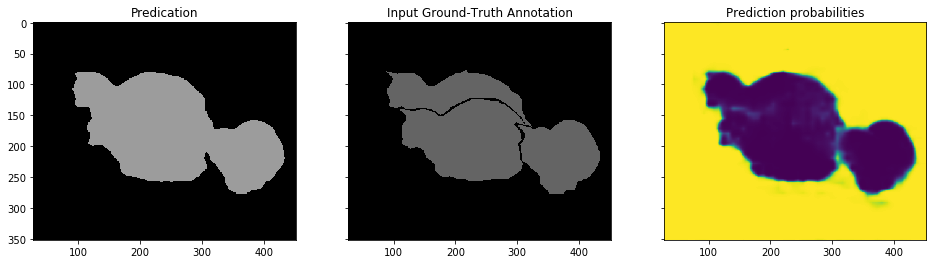

Train step: 53 	Traing Loss: 0.0360197 	mIOU: 0.0860945


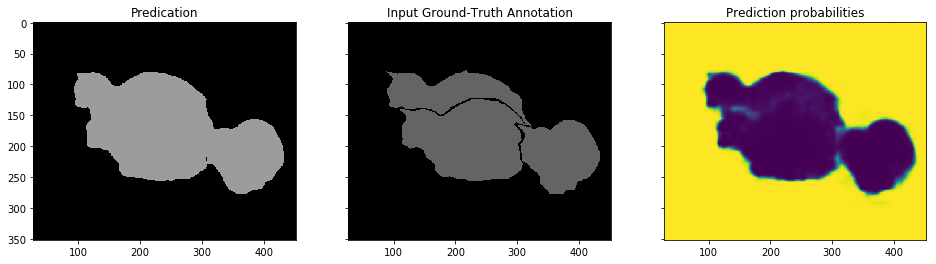

Train step: 54 	Traing Loss: 0.0368833 	mIOU: 0.0862019


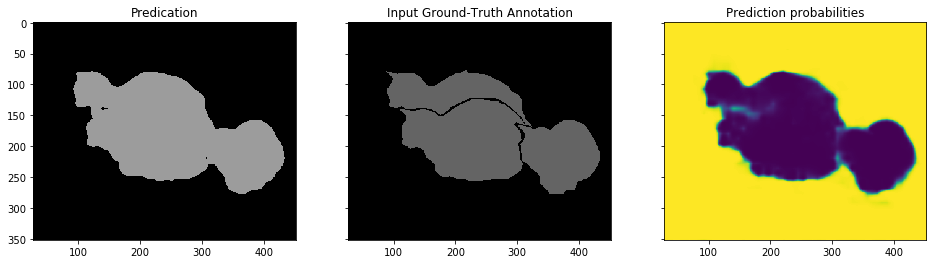

Train step: 55 	Traing Loss: 0.0348929 	mIOU: 0.0863034


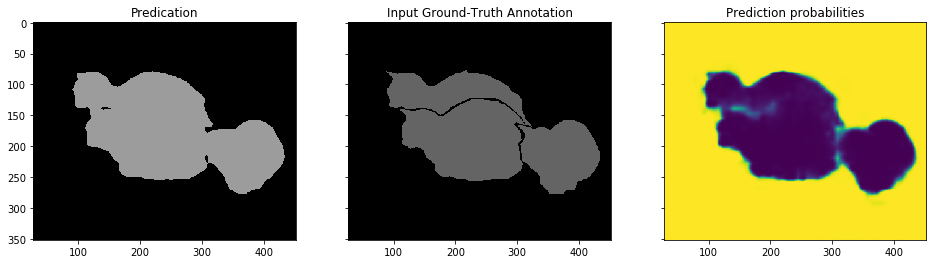

Train step: 56 	Traing Loss: 0.0366887 	mIOU: 0.0863981


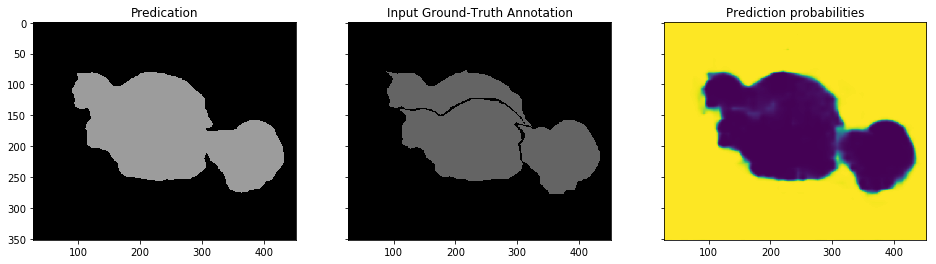

Train step: 57 	Traing Loss: 0.0356351 	mIOU: 0.0864921


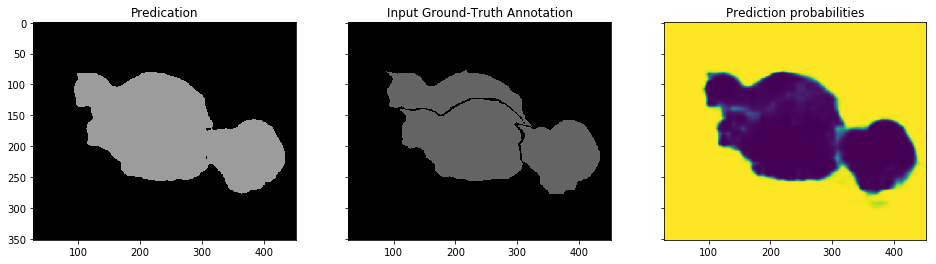

Train step: 58 	Traing Loss: 0.0364668 	mIOU: 0.0865805


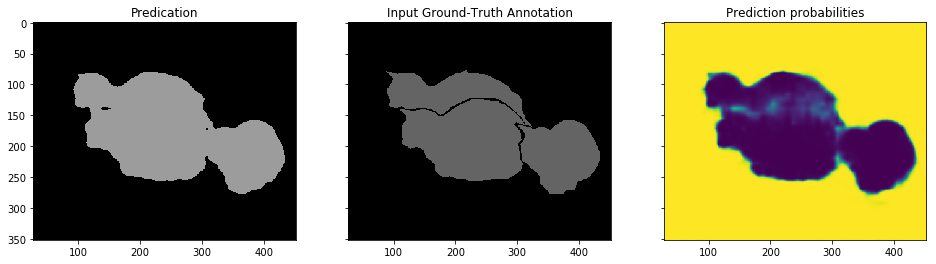

Train step: 59 	Traing Loss: 0.0347132 	mIOU: 0.0866706


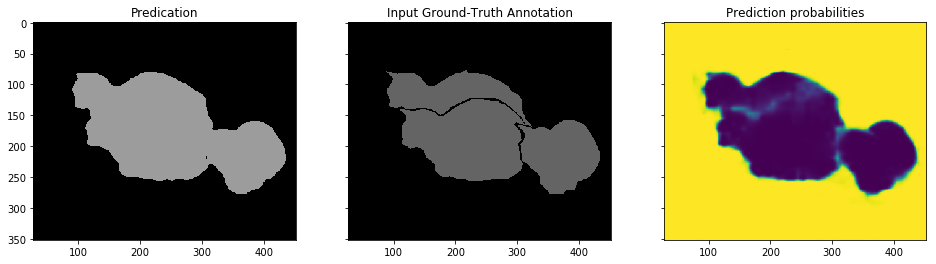

Train step: 60 	Traing Loss: 0.0349679 	mIOU: 0.0867573


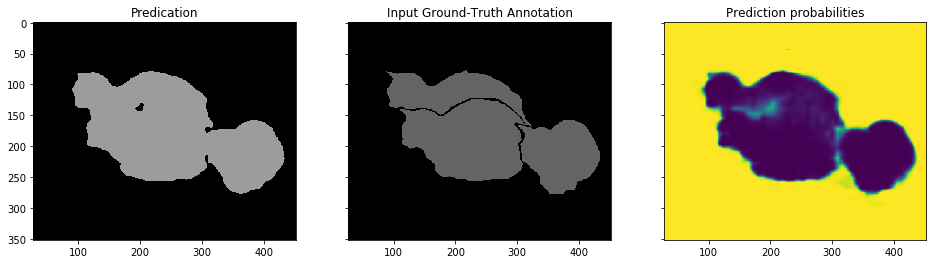

Train step: 61 	Traing Loss: 0.0351035 	mIOU: 0.0868398


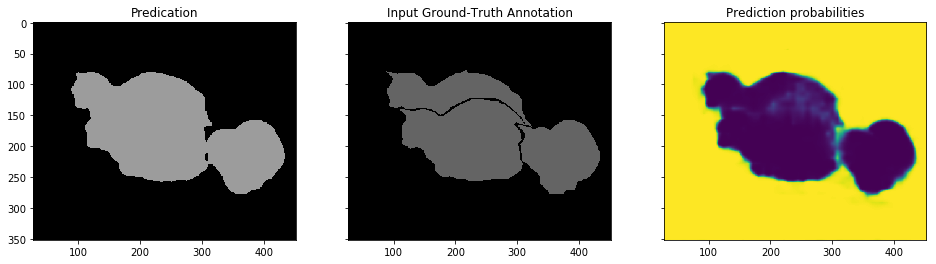

Train step: 62 	Traing Loss: 0.0343892 	mIOU: 0.0869184


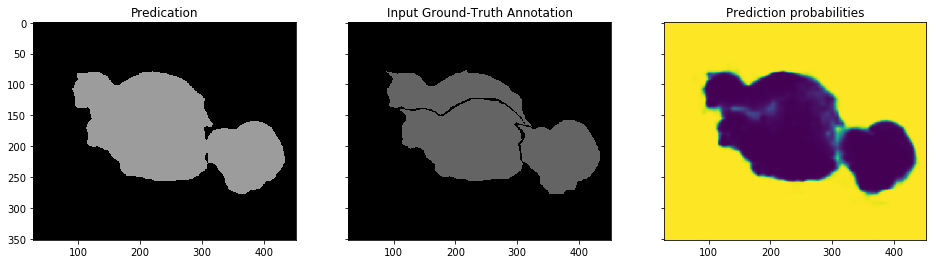

Train step: 63 	Traing Loss: 0.0337597 	mIOU: 0.0870009


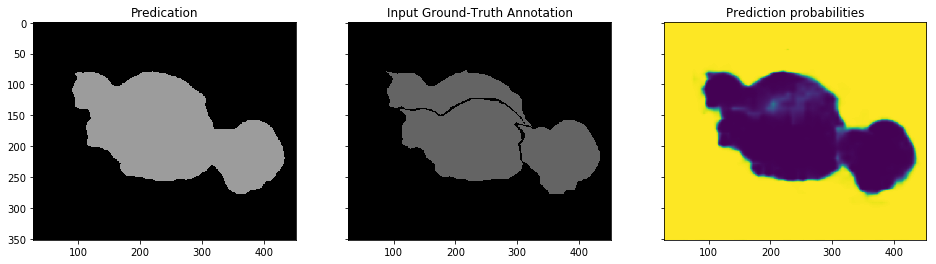

Train step: 64 	Traing Loss: 0.0342089 	mIOU: 0.0870798


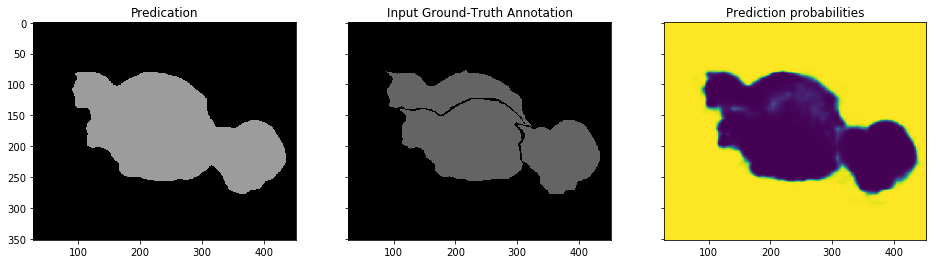

Train step: 65 	Traing Loss: 0.0338504 	mIOU: 0.0871538


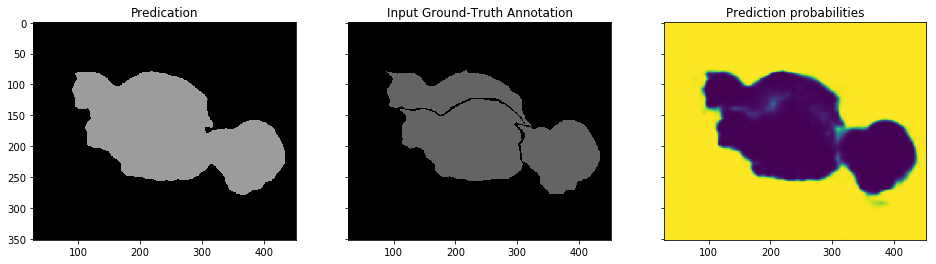

Train step: 66 	Traing Loss: 0.0350996 	mIOU: 0.0872228


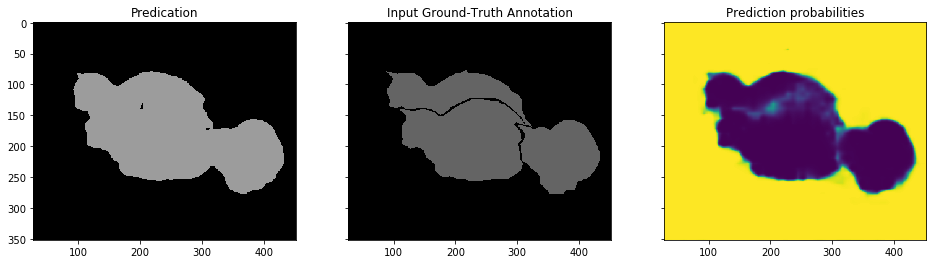

Train step: 67 	Traing Loss: 0.0333862 	mIOU: 0.0872947


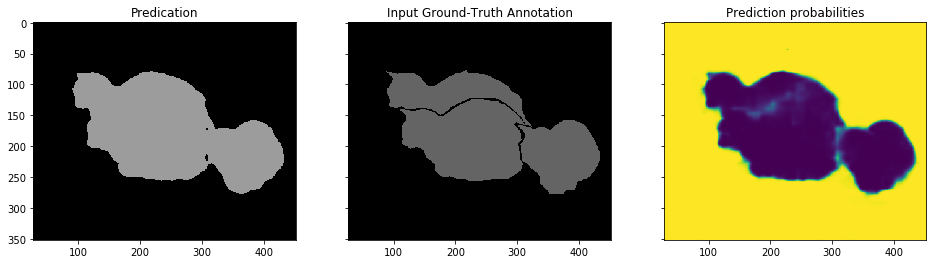

Train step: 68 	Traing Loss: 0.0335232 	mIOU: 0.0873646


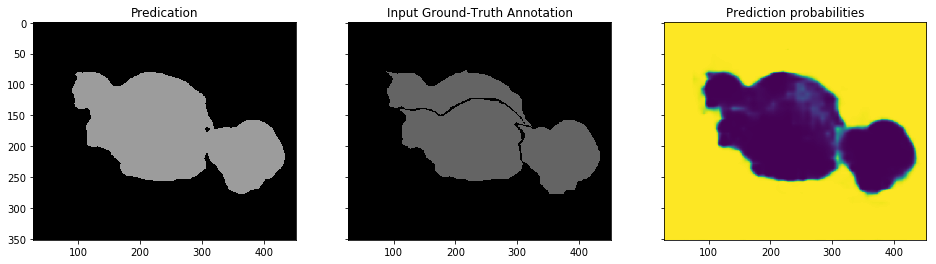

Train step: 69 	Traing Loss: 0.033964 	mIOU: 0.0874297


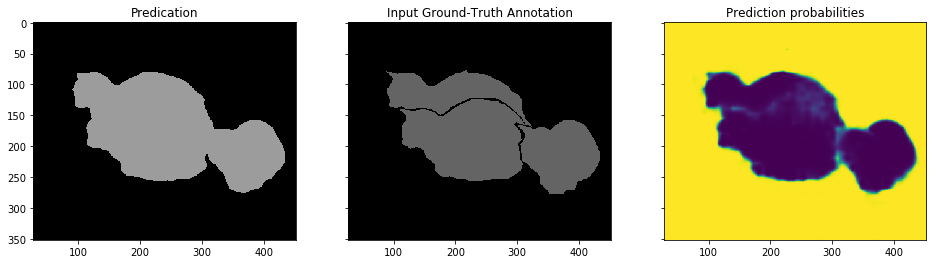

Train step: 70 	Traing Loss: 0.0316538 	mIOU: 0.0874973


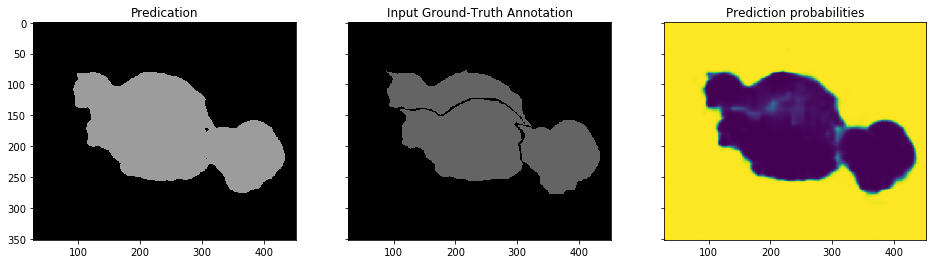

Train step: 71 	Traing Loss: 0.0321892 	mIOU: 0.08756


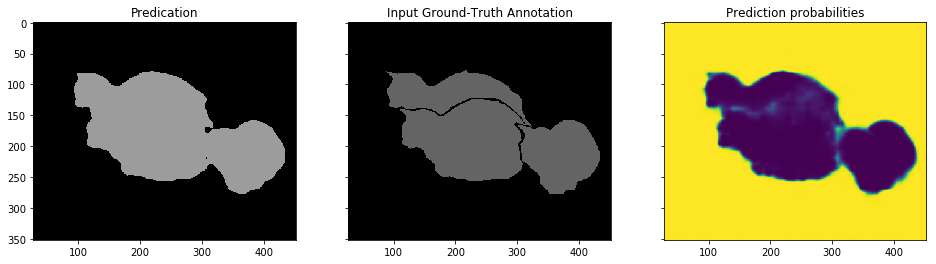

Train step: 72 	Traing Loss: 0.0329629 	mIOU: 0.0876213


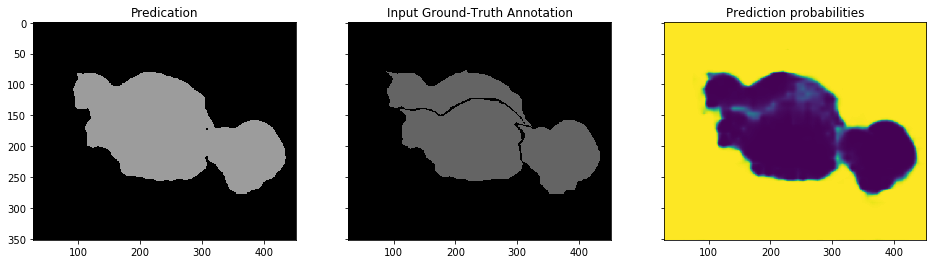

Train step: 73 	Traing Loss: 0.0323039 	mIOU: 0.0876865


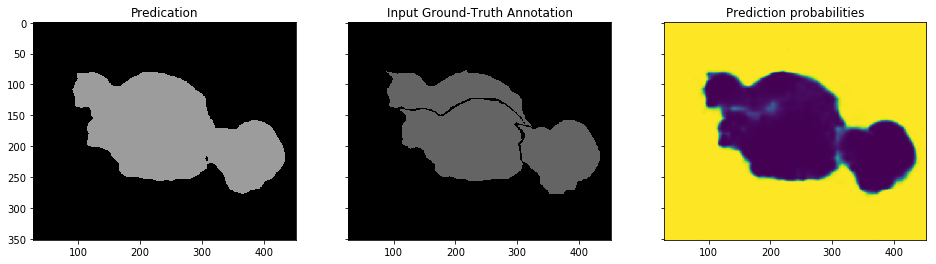

Train step: 74 	Traing Loss: 0.0324321 	mIOU: 0.0877473


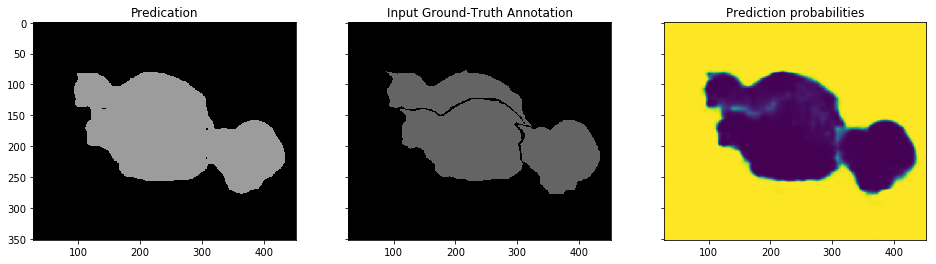

Train step: 75 	Traing Loss: 0.0324619 	mIOU: 0.0878054


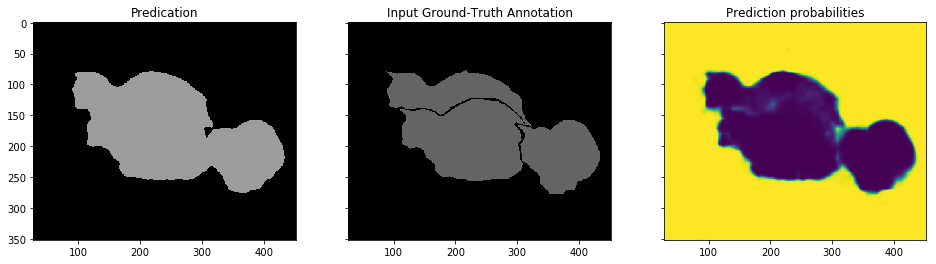

Train step: 76 	Traing Loss: 0.0315874 	mIOU: 0.0878639


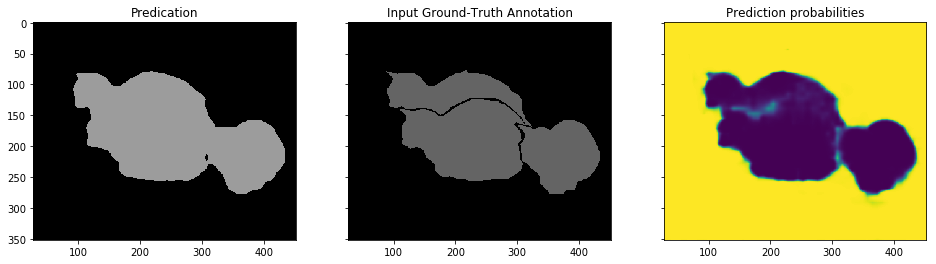

Train step: 77 	Traing Loss: 0.0313689 	mIOU: 0.087922


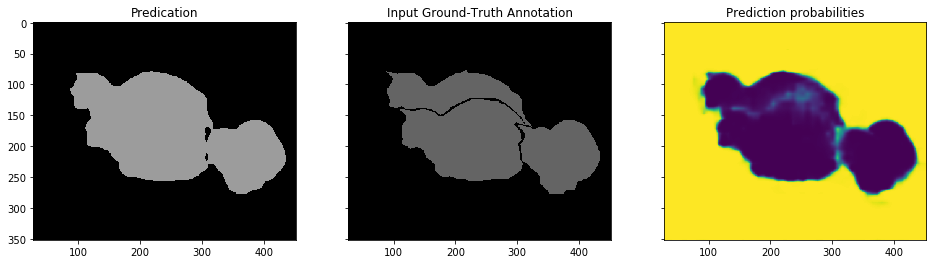

Train step: 78 	Traing Loss: 0.0326921 	mIOU: 0.0879768


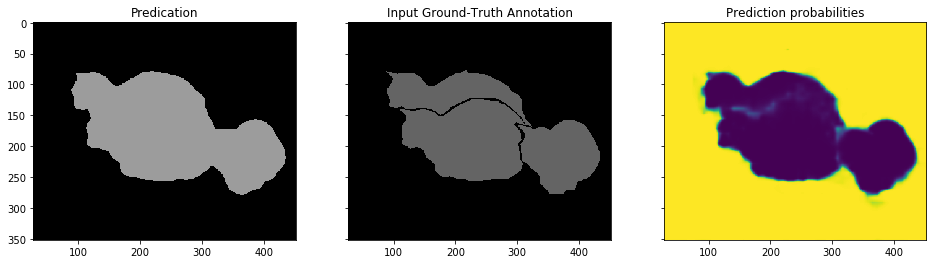

Train step: 79 	Traing Loss: 0.0305608 	mIOU: 0.0880324


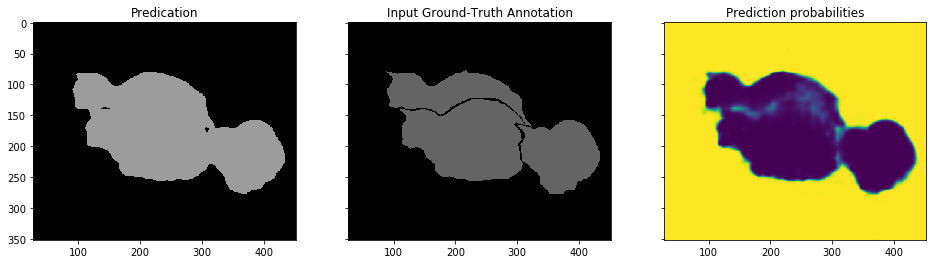

Train step: 80 	Traing Loss: 0.0310635 	mIOU: 0.088085


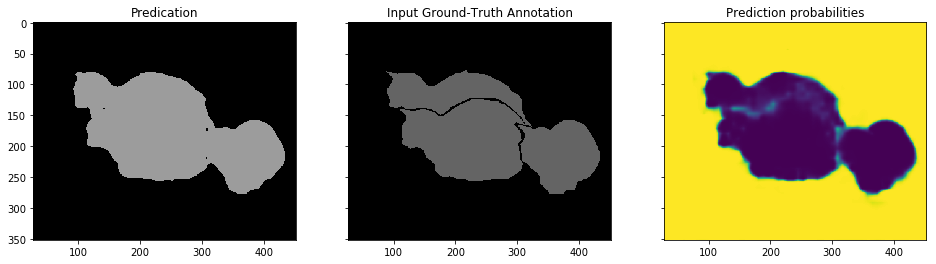

Train step: 81 	Traing Loss: 0.031891 	mIOU: 0.0881376


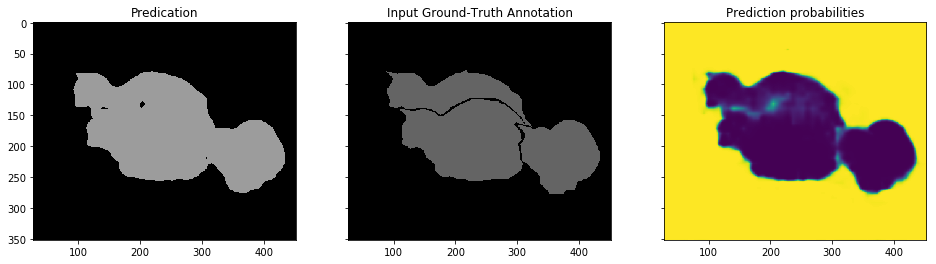

Train step: 82 	Traing Loss: 0.0308291 	mIOU: 0.0881876


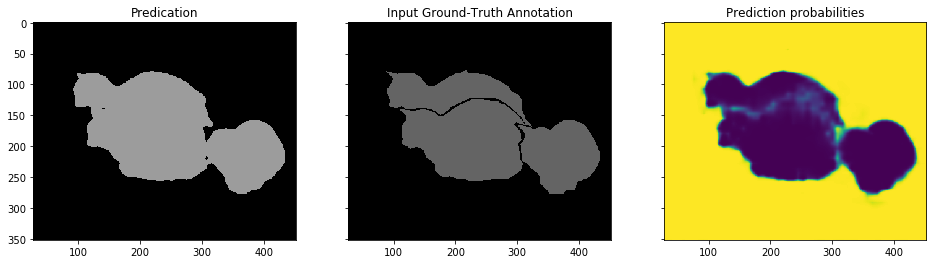

Train step: 83 	Traing Loss: 0.0310257 	mIOU: 0.0882378


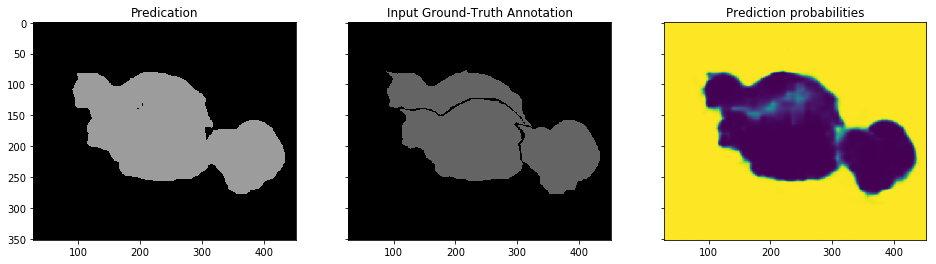

Train step: 84 	Traing Loss: 0.0321023 	mIOU: 0.0882817


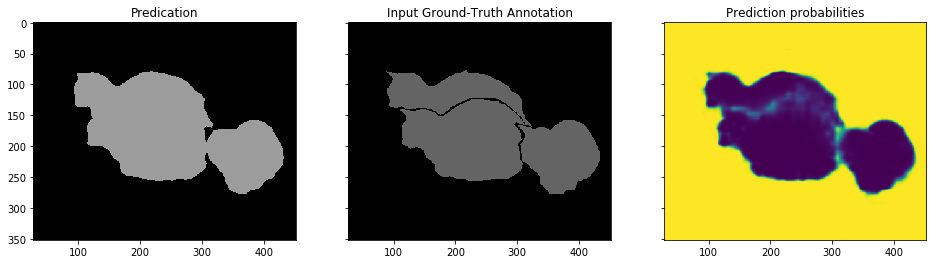

Train step: 85 	Traing Loss: 0.0316012 	mIOU: 0.0883276


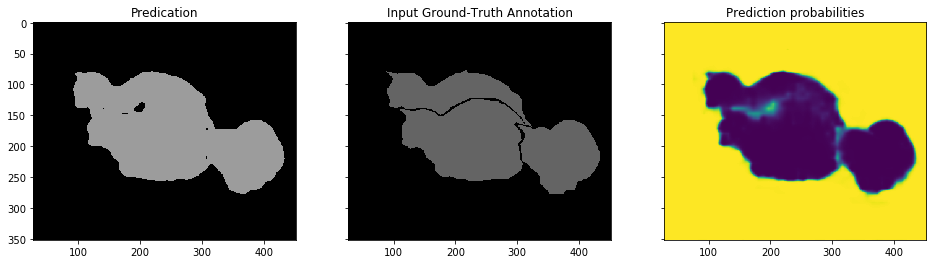

Train step: 86 	Traing Loss: 0.0305114 	mIOU: 0.0883725


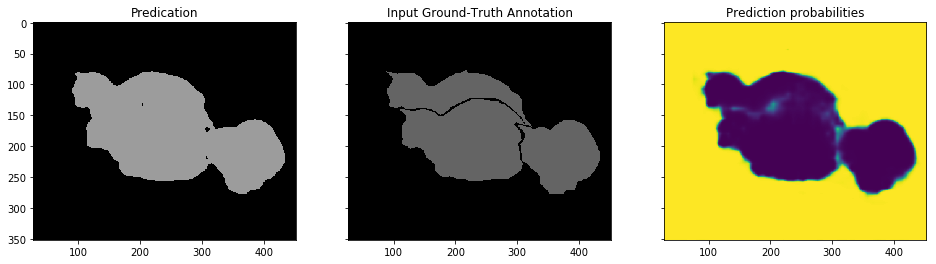

Train step: 87 	Traing Loss: 0.0314599 	mIOU: 0.0884166


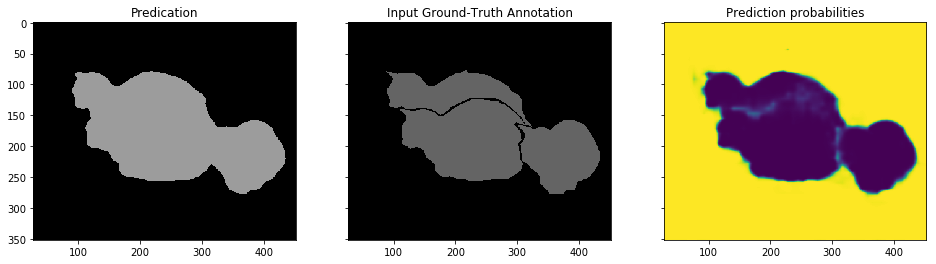

Train step: 88 	Traing Loss: 0.0299546 	mIOU: 0.0884607


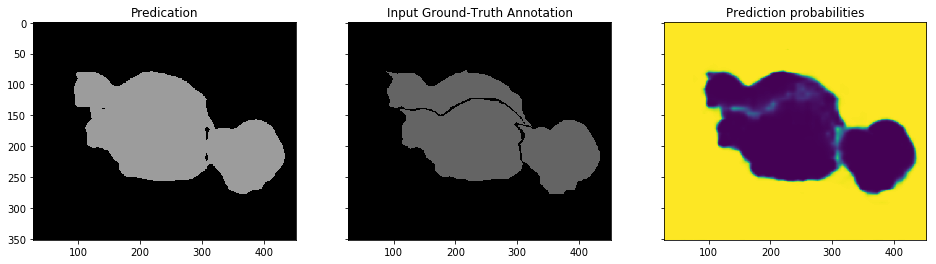

Train step: 89 	Traing Loss: 0.0318502 	mIOU: 0.0885021


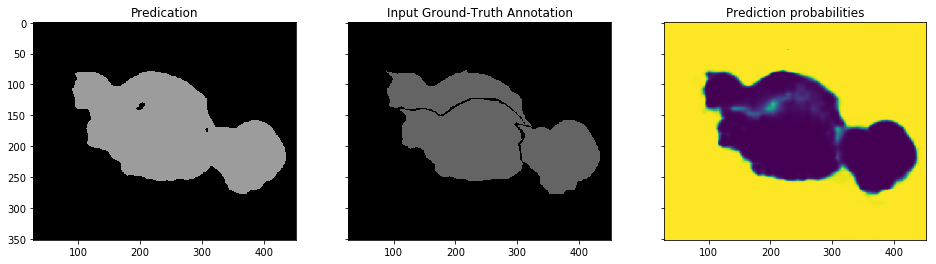

Train step: 90 	Traing Loss: 0.0300815 	mIOU: 0.0885436


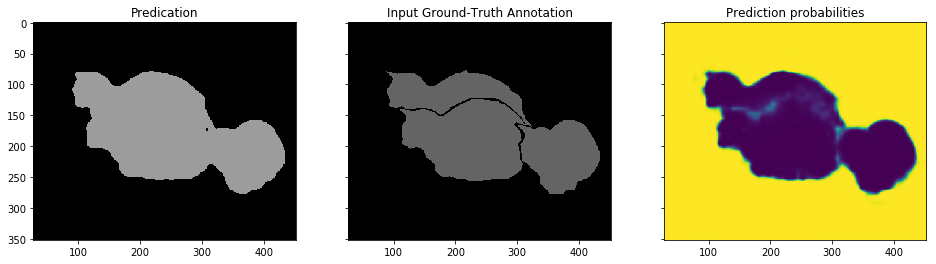

Train step: 91 	Traing Loss: 0.0317177 	mIOU: 0.0885828


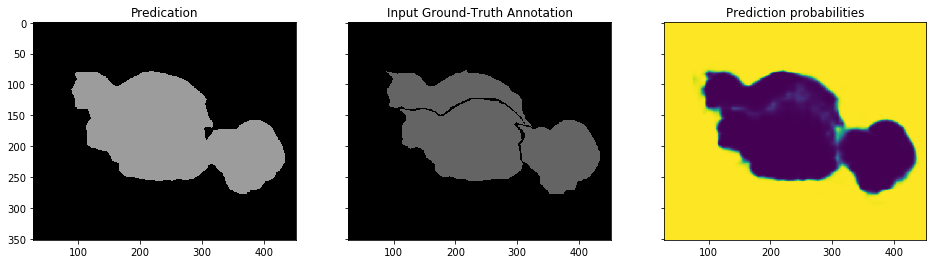

Train step: 92 	Traing Loss: 0.0294022 	mIOU: 0.0886236


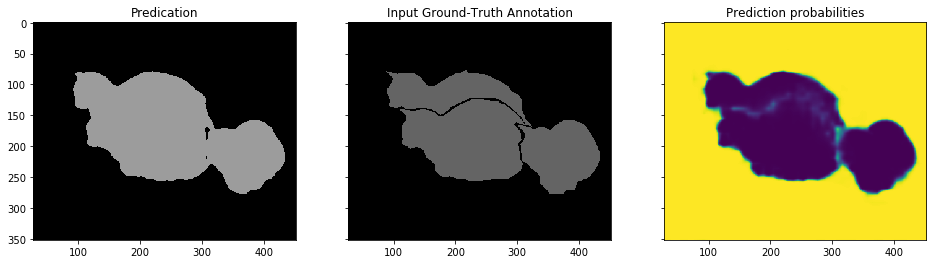

Train step: 93 	Traing Loss: 0.0305763 	mIOU: 0.0886622


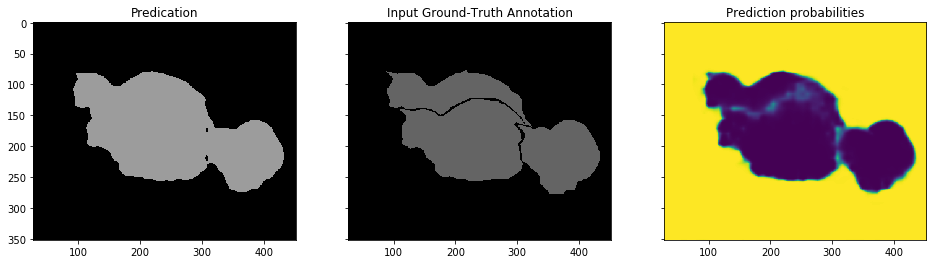

Train step: 94 	Traing Loss: 0.0303254 	mIOU: 0.0886993


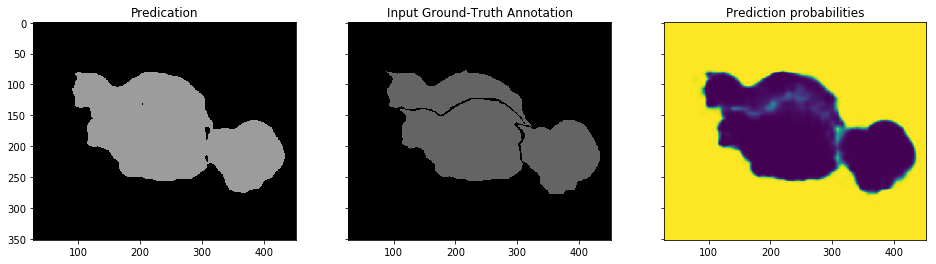

Train step: 95 	Traing Loss: 0.0309592 	mIOU: 0.088735


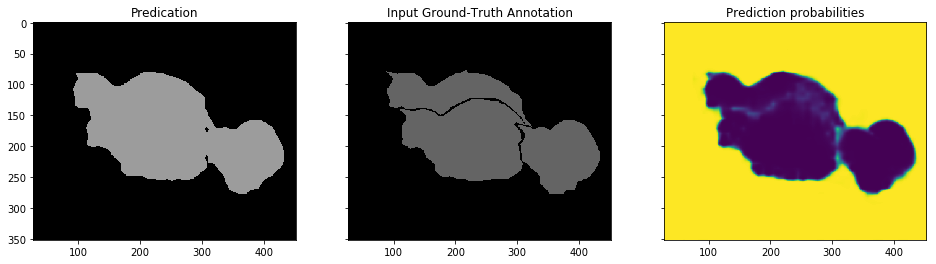

Train step: 96 	Traing Loss: 0.0301574 	mIOU: 0.0887724


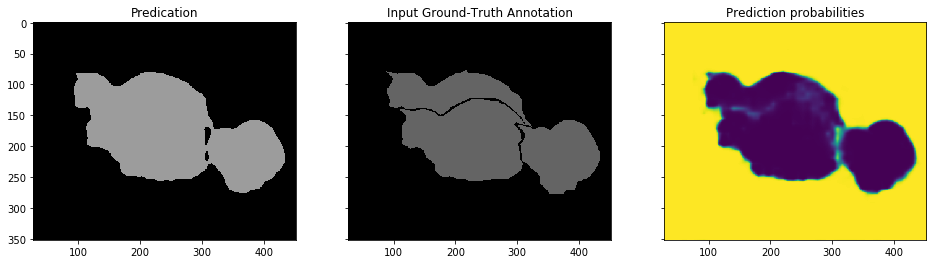

Train step: 97 	Traing Loss: 0.0291612 	mIOU: 0.0888109


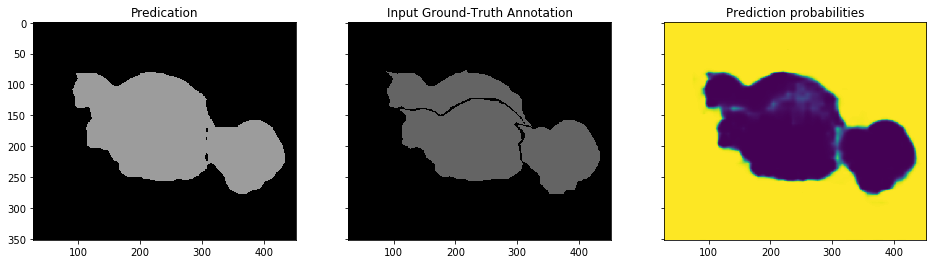

Train step: 98 	Traing Loss: 0.0297707 	mIOU: 0.0888467


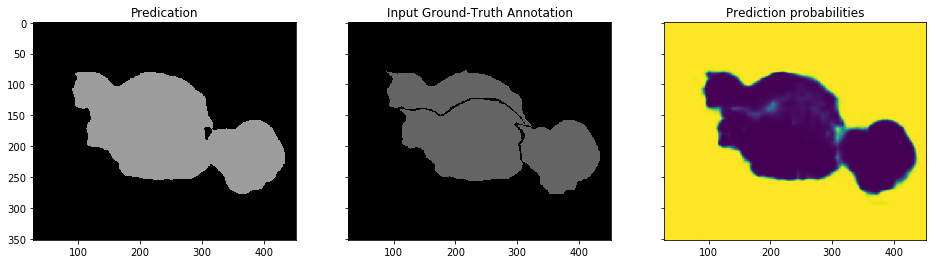

Train step: 99 	Traing Loss: 0.029446 	mIOU: 0.0888829


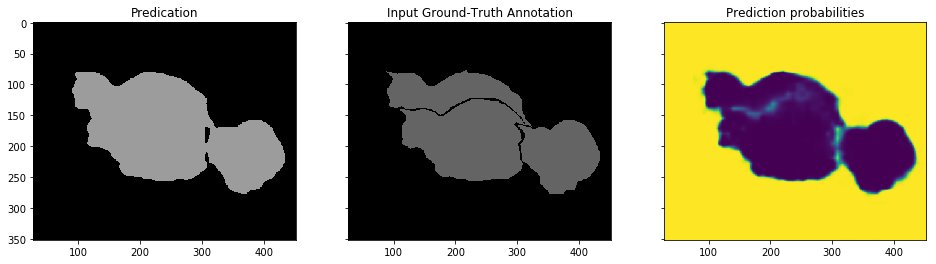

In [15]:
# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

model_vars = tf.variables_initializer(model_variables)

# Create a saver.
saver = tf.train.Saver()

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    sess.run(tf.local_variables_initializer())
    sess.run(model_vars)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict={is_training_placeholder: False})
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figheight(4)
    f.set_figwidth(10)
    ax1.imshow(train_image[0])
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    for step in range(100):

        _, train_loss, pred_np, probabilities_np, tmp = sess.run([train_step, cross_entropy_sum, pred, probabilities, update_op],
                                        feed_dict={is_training_placeholder: True})
        miou_np = sess.run(miou)
        
        pred_annotation = np.expand_dims(pred_np[0], axis=2).astype(float)
        print("Train step:", step, "\tTraing Loss:", train_loss, "\tmIOU:", miou_np)

        cmap = plt.get_cmap('bwr')
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        f.set_figheight(4)
        f.set_figwidth(16)

        ax1.imshow(np.dstack((pred_annotation,)*3)*100)
        ax1.set_title('Predication')
        probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
        ax2.set_title('Input Ground-Truth Annotation')
        probability_graph = ax3.imshow(probabilities_np.squeeze()[:, :, 0])
        ax3.set_title('Prediction probabilities')
        plt.show()

    sess.close()

    summary_string_writer.close()